# Employee Retention Data Challenge

## Goal

Employee turn-over is a very costly problem for companies. The cost of replacing an employee can be large (>100K USD), taking into account both the sunk costs spent recruiting and signing the employee, the decrease in productivity while searchig for a replacement, as well as the costs of finding a new employee. Thus, improving employee retention is a good investment in any venture. In this data challenge, I was given a data set with info about employees focused on predicting when an employee might quit by understanding the main drivers of employee churn.

## Challenge Description

We were given data about all employees who joined multiple comnpnaies between 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13, or if they  quit. Beside that, we have general info about the employee, such as avg salary during thier tenure, department within the company, and years of experience prior to joining the company.

The individual goals of this challange are to:

* Estimate the number of employees at each company for each day, assuming that the headcount starts from zero on 2011/01/23.

* Determine the main factors driving employee churn, and how they make sense.

* Suggest additional data that could help explain employee churn

## Data

We have 1 table. The table is:

Columns:
* employee_id : id of the employee. Unique by employee per company company_id : company id.
* dept : employee dept
* seniority : number of yrs of work experience when hired
* salary: avg yearly salary of the employee during her tenure within the company join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13
* quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)


We start by importing some packages we'll use, as well as the data from a CSV file

In [1306]:
# Import some packages we'll use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
import seaborn as sns
from itertools import product
import lifelines as ll
from sklearn.preprocessing import scale
import scipy.stats  as stats
from lifelines.statistics import logrank_test
from lifelines.utils import k_fold_cross_validation

In [1183]:
# Import the data into a Pandas dataframe

employee_retention = pd.read_csv("/Users/scottmorello/Dropbox/Archives/Jobs/Insight_Data_Science/Data_Challenges/Data_Challenge_1/employee_retention_data.csv")

Let's explore the first few lines of data, and then some summary tables.

In [1184]:
employee_retention.head(5)

employee_id  company_id              dept  seniority    salary   join_date  \
0      13021.0           7  customer_service         28   89000.0  2014-03-24   
1     825355.0           7         marketing         20  183000.0  2013-04-29   
2     927315.0           4         marketing         14  101000.0  2014-10-13   
3     662910.0           7  customer_service         20  115000.0  2012-05-14   
4     256971.0           2      data_science         23  276000.0  2011-10-17   

    quit_date  
0  2015-10-30  
1  2014-04-04  
2         NaN  
3  2013-06-07  
4  2014-08-22

We can already see that there are some NaNs in dates, as suggested by the file's metadata. The variables generally fall in line with what was described though.

I start summarizing the data - fixing data types (e.g., turning dates into datetime obejects), calculating new featurs (e.g., churn time), looking for outliers and NAs to fix, and assessing the approximate distributions of the data.

Let's start by fixing datatypes

In [1185]:
# look at the data types for each column

employee_retention.dtypes

employee_id    float64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object

In [1186]:
# convert the date columns to dates
employee_retention['join_date'] = pd.to_datetime(employee_retention['join_date'])
employee_retention['quit_date'] = pd.to_datetime(employee_retention['quit_date'])

employee_retention.dtypes

employee_id           float64
company_id              int64
dept                   object
seniority               int64
salary                float64
join_date      datetime64[ns]
quit_date      datetime64[ns]
dtype: object

We will eventually need to know how long it took for an employee to churn, so that's calculate that

In [1187]:
# add a column for the time until churn for each employee
employee_retention['churn_time'] = (employee_retention['quit_date'] - employee_retention['join_date']).dt.days

# and a column as a boolean for whether an employee churned or not
employee_retention['churn_binary'] = pd.notnull(employee_retention['quit_date'])


In [1188]:
# we look for Null values, expecting they will only occur in the "quit_date" and original "churn_time" columns, where 
# they represent individuals still active at a company
employee_retention
employee_retention.isnull().sum()

employee_id         0
company_id          0
dept                0
seniority           0
salary              0
join_date           0
quit_date       11192
churn_time      11192
churn_binary        0
dtype: int64

The only NA values in the dataset occur in the "quit_date" and "churn_time" columns, and represent active employees, so no need to remove any rows for null value reasons.

To take a first look at the data distributions, we'll need to make dummy variables for department, since it's the only non-numeric datatype at the moment

In [1189]:
# We code a dummy variable for departments, and look at the unique values
unique_depts, employee_retention['deptDummy'] = np.unique(employee_retention.dept, return_inverse=True)
print "department names: " + str(unique_depts)

department names: ['customer_service' 'data_science' 'design' 'engineer' 'marketing' 'sales']


Now let's plot the data in a scatter matrix to look at relationships and distributions

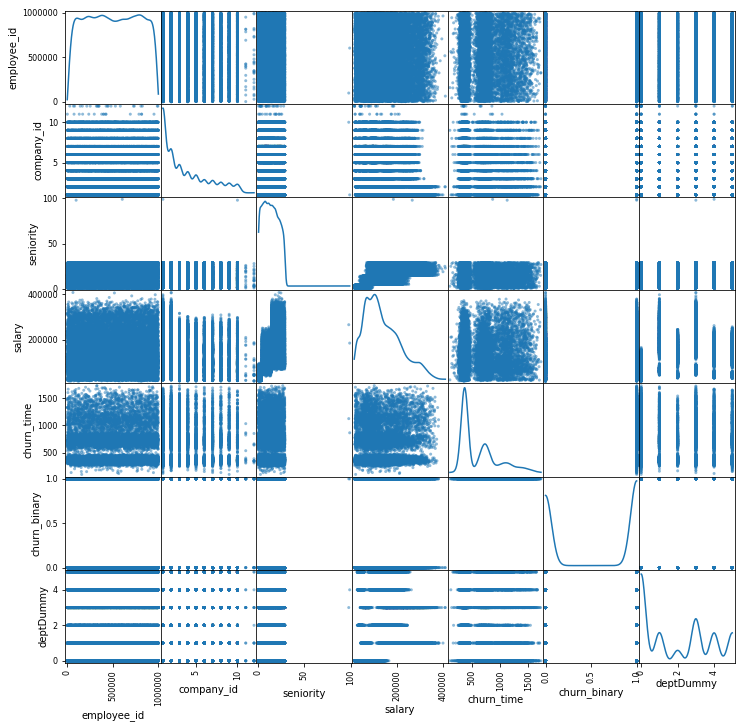

In [1190]:
# This is a better way to get a quick look at the data, and include catigorical variables. We force the diagonal
# (ie., the distributions of each varable) to be a denisty fuction, so we can asses the distributions.
pd.plotting.scatter_matrix(employee_retention, figsize=(12, 12), diagonal='kde')
plt.show()

### Outliers and Sample Sizes
The data above already suggest major outliers in Seniority (>50) in the engineering (id 3) and Marketing (id 4) departments. The samples are also a little sparce for company IDs >10.

To Do:
* remove outliers in seniority > 50
* check on sparce data for comapny IDs > 10... small companies?

### Types of data
The summaries also suggest that company ID should be treated as a factor (needs to be turned into an int istead of a float beforehand). Employee ID is probably going to overlap among companies, so we'll need to combine that label with company ID if we want something truely unique. Also, there are 2 peaks in Churn Time, and the Customer Service department (id 0) seems to have more data overall (and employees?) than other departments.

To Do:
* convert company_id to an int and then to a category
* check that employee id's don't overlap by company, and if so, create a unique_id for each individual

### Relationships to Consider
Seniority (numbner of years experience prior to hire) and salary seem to be related, which could become a problem in terms of multi-colinearity. Additionally, salary seems to jump based on clusters of seniority. If we want to include both of these varables in an analysis, we'll either need to develop a new feature that reflects clusters of salary and seniority, or determine which is most important to the model.

To Do:
* engineer a feature reflecting clusters in the seniority-salary relationship

### Distributions
The obviously continuous variables, Salary and Churn Time, are right-skewed as would have been suspected. We could deal with this with either a log(x) transformation if one of our analyses assumes normality, or by using a model/statistical test where we can specify a different distribution (e.g., Poisson). This might be more complicated for churn_time, since there are ovviously two peaks, but that will depend on the analsyis (e.g., a survivability analysis won't need any transformation). The double peak is curious however, and we should look at whether the peaks reflect different companies or departments, or whether these are an inherent feature in churn where employees churn after 2 specific periods of time

To Do:
* Consider that Salary and Churn Time are right skewed (might require transformations or specifying differnt distributiions)
* Check whether the dounble peak in Churn Time is parsed out by company and/or department, or whether employees just churn after certai periods of time.

### Variations among groups
It already looks as if some companies (companies with lower IDs) have higher salaries than others (companies with higher IDs). The companies with with highest IDs are also the ones with sparse data, suggesting they are small companies. We will probably need to create a new feature for "company_size" and look into that relationship. Data Scientists (id 1) and engineers (id 3) also seem to have higher salaries than other departments.

To Do:
* Create a feature for compamny size
    * check if comapny size relates to salary
* Consider that Data Science (id 1) and engineering (id 3) departments seem to have higher salaries than others

Let's start by removing the outliers in seniority

In [1191]:
# remove the outliers
employee_retention = employee_retention[employee_retention.seniority<50]

Now, lets look into that relationship between seniority and salary, and engineer some clusters to account for both

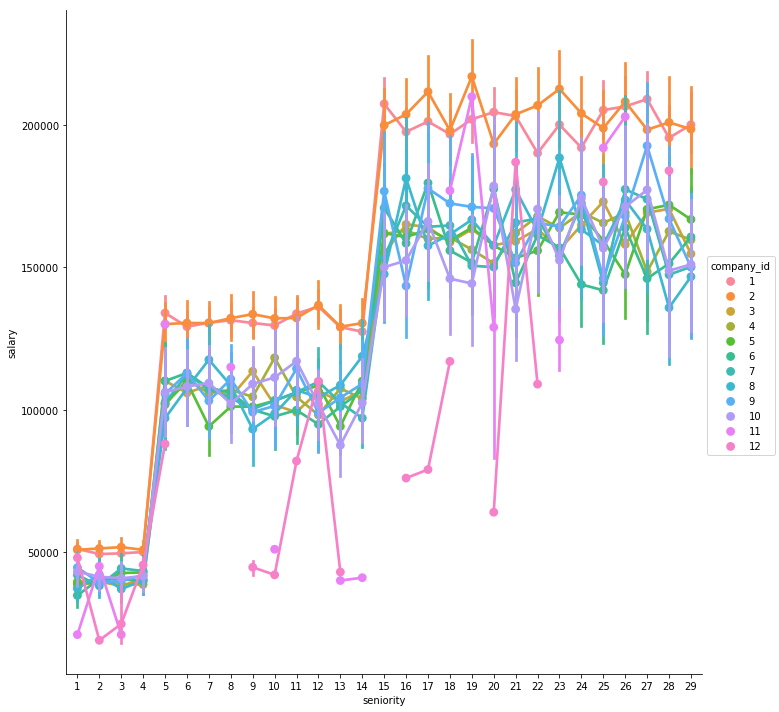

In [1192]:
# I look at the seniority by salary, and find that it clusters pretty well.
sns.factorplot(x="seniority", y="salary", hue="company_id", data=employee_retention,size=10)
plt.show()

In [1193]:
#I decide to engineer a feature that groups seniority into bins
def groupSeniority(x):
    val = x
    if val < 5:
        return 1
    elif val>=5 and x<15:
        return 2
    else:
        return 3

seniority_group = employee_retention.seniority.apply(lambda x: groupSeniority(x))
employee_retention['seniority_group'] = seniority_group

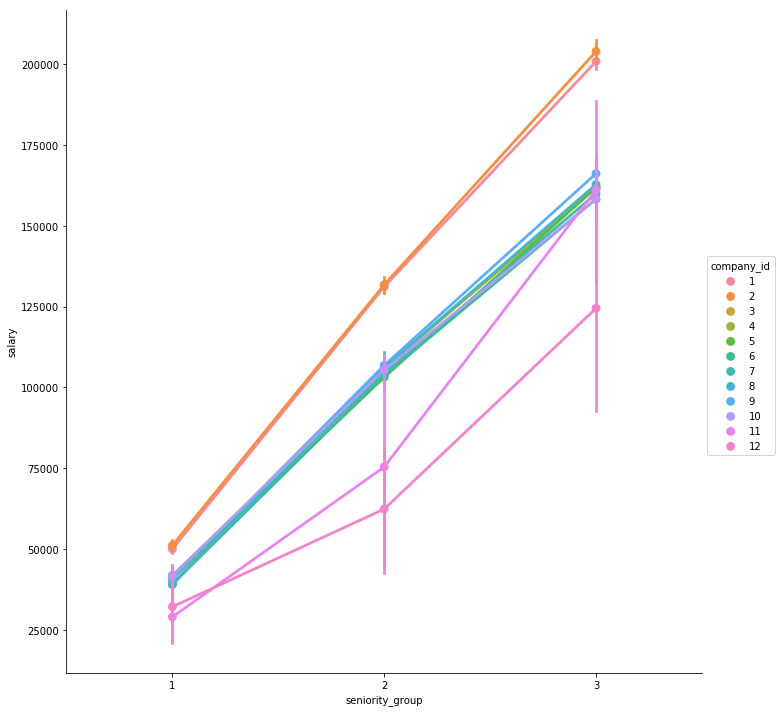

In [1194]:
# This looks much better now
sns.factorplot(x="seniority_group", y="salary", hue="company_id", data=employee_retention,size=10)
plt.show()

Now that we've created this feature, it can represent increases in both seniority AND salary at the same time. Any inference based on the feature can be investigated further.

Now let's look at creating a unique_id for each employee

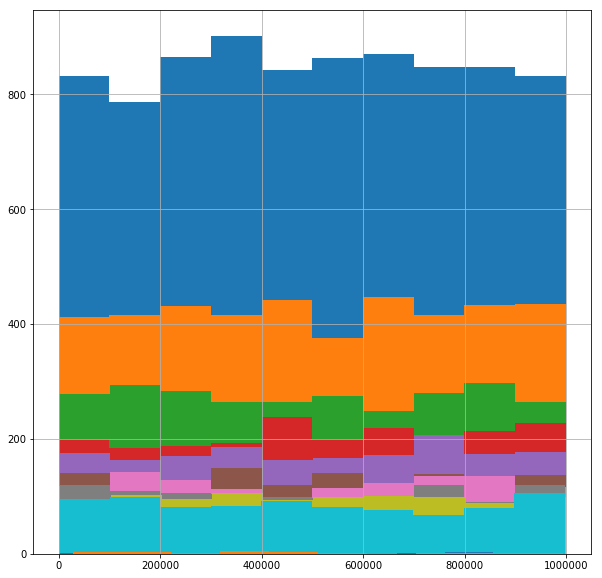

In [1195]:
# Investigating the emploee ID by Company ID issue
employee_retention.groupby('company_id').employee_id.hist(alpha=0.4,figsize=(10,10))
plt.show()

As suspected, there's a lot of overlap in employee_id and company_id. If we want a truely unique ID, we should combine the two

In [1196]:
# converting floats to ints, then to factors/categories for companies, and strings for employees since 
# it wouldn't make sense for them to be treated as a continuous variable accidentily
employee_retention.company_id = employee_retention.company_id.astype(int).astype("category")
employee_retention.employee_id = employee_retention.employee_id.astype(int).astype(str)

In [1197]:
# Combine the columns into a unique ID
employee_retention['unique_id']=employee_retention['company_id'].astype(str)+'_'+employee_retention['employee_id'].astype(str)

In [1198]:
# Take a look at the new IDs
print employee_retention.unique_id[:10]

0     7_13021
1    7_825355
2    4_927315
3    7_662910
4    2_256971
5    4_509529
6     4_88600
7    2_716309
8    9_172999
9    1_504159
Name: unique_id, dtype: object


In [1199]:
# We check to make certain that the maximum count for each unique_id is 1
print employee_retention.groupby('unique_id').count().max()

employee_id        1
company_id         1
dept               1
seniority          1
salary             1
join_date          1
quit_date          1
churn_time         1
churn_binary       1
deptDummy          1
seniority_group    1
dtype: int64


Good, there is only one line of data per unique_id.

Now let's work on estimating company size (number of employees), and perhaps creating a new feature from that.

company_id
1     3865
2     2016
3     1218
4      909
5      772
6      579
7      532
8      468
9      432
10     385
11       4
12      12
Name: unique_id, dtype: int64


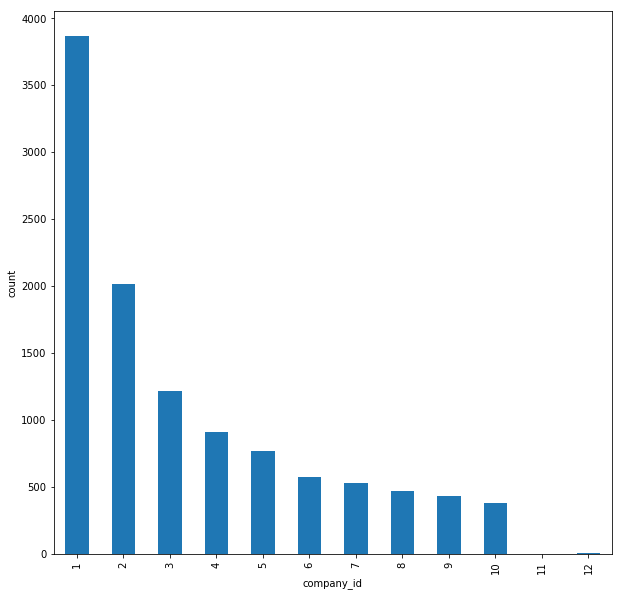

In [1200]:
# to remove any confounding influce of employee churn, let's base our company size estimates only on employees
# that remained by the end of the study period. This is reflected by NaN values in 'quit_date'
company_size = employee_retention[pd.isnull(employee_retention['quit_date'])].groupby('company_id').unique_id.count()
print company_size
company_size.plot.bar().set_ylabel("count")

plt.show()

Let's try to cluster the companies using K-Means cluster in a univariate way, and base the clusters on number of employees

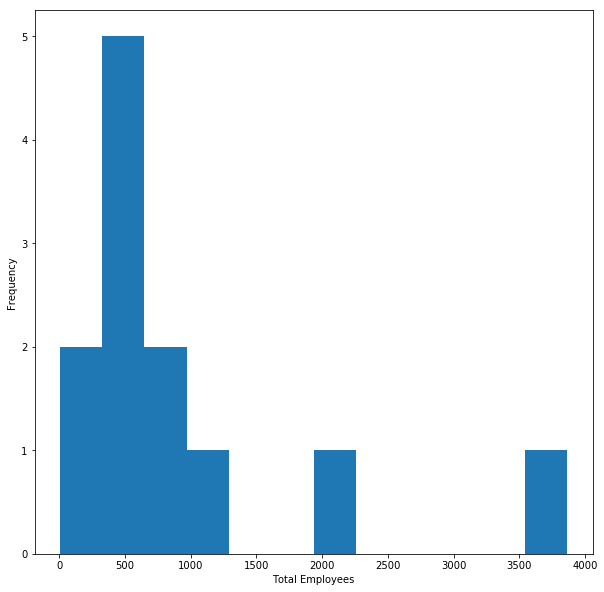

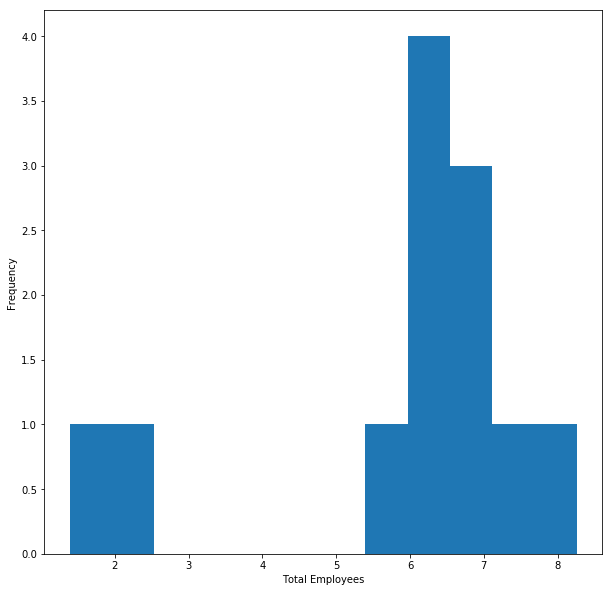

In [1201]:
# We'll try to do univariate clustering with k-means, but we'll first need to transform the data so that
# the distribution of employee counts is more linear, since k-means is evaluating distances to group centers
# linearly
data_to_cluster = employee_retention[pd.isnull(employee_retention['quit_date'])].groupby('company_id').unique_id.count()
data_to_cluster_transformed = np.log(data_to_cluster)

data_to_cluster.plot.hist(bins=len(data_to_cluster)).set_xlabel("Total Employees")
plt.show()
data_to_cluster_transformed.plot.hist(bins=len(data_to_cluster_transformed)).set_xlabel("Total Employees")
plt.show()

In [1202]:
# It looks like 4 clusters based on the 
company_size_clusters = KMeans(n_clusters=4).fit(data_to_cluster_transformed.values.reshape(-1,1))

In [1203]:
cluster_id = company_size_clusters.predict(data_to_cluster_transformed.values.reshape(-1,1)).tolist()

cluster_df = pd.DataFrame(
    {'company_id': (np.arange(12)+1).tolist(),
     'companySize':company_size,
     'companySize_cluster': cluster_id
    })
print cluster_df

            companySize  companySize_cluster  company_id
company_id                                              
1                  3865                    2           1
2                  2016                    2           2
3                  1218                    3           3
4                   909                    3           4
5                   772                    3           5
6                   579                    0           6
7                   532                    0           7
8                   468                    0           8
9                   432                    0           9
10                  385                    0          10
11                    4                    1          11
12                   12                    1          12


We can see how the clusters fall out, which looks good subjectively.

Now we'll match these clusters to the original data

In [1204]:
# now match up the data so we have company size cluster info with the original data
employee_retention = pd.merge(employee_retention, cluster_df, left_on = ['company_id'], right_on = ['company_id'])

Let's look at clustering in the employee start and end dates now, to understand if there were cluster-hires, and peaks in churn, and get an idea of how we might begin to understand churn.

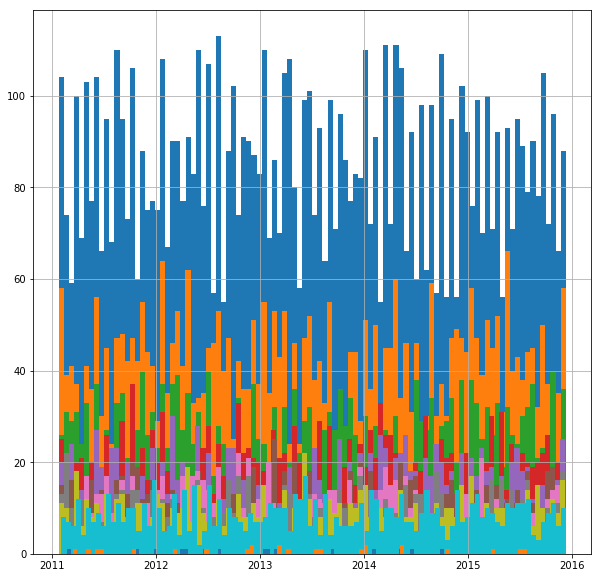

In [1205]:
employee_retention.groupby('company_id').join_date.hist(bins=100,alpha=0.4,figsize=(10,10))
plt.show()

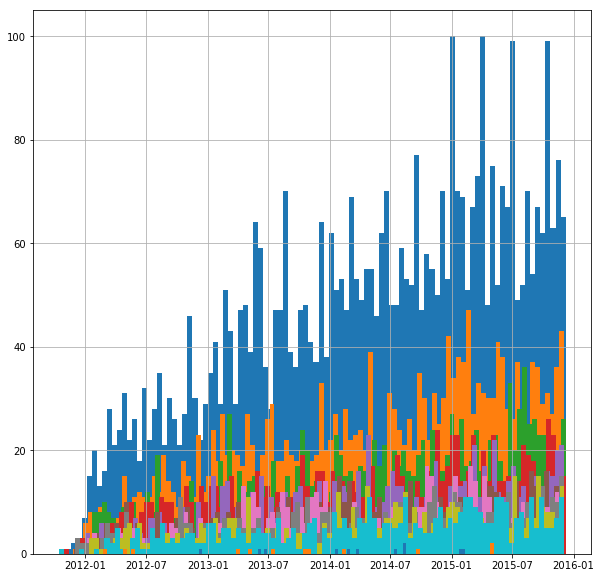

In [1206]:
employee_retention.groupby('company_id').quit_date.hist(bins=100,alpha=0.4,figsize=(10,10))
plt.show()

Hires don't vary much across years by company (i.e., hiring rate is pretty consistent), but churns increases with time, the slope of which seems to be interacting with company size. Also, there seem to be periods (months?) where hires and churns are greatest. We should look into summarizing this, as well as employee number at any given moment.

Let's start by estiamting company size (# of employees) for any given dayt for any given company. We can do this itteratively by day, adding hires and subtracting quits.

In [1207]:
#I create a new dataframe with employee count by day
allDates = pd.date_range(start = datetime(2011,01,23), end = datetime(2015,12,13))
employeeCount_df = pd.DataFrame(list(product(allDates, employee_retention.company_id.unique())), columns=['Date', 'company_id'])

def getEmployeeCount(x):
    curretDate = x.Date
    curretCompany = x.company_id
    return employee_retention[(employee_retention['join_date'] <= curretDate) &
                           ((employee_retention['quit_date'] > curretDate) | 
                            pd.isnull(employee_retention['quit_date'])) &
                             (employee_retention['company_id'] == curretCompany)].unique_id.count()


EmployeeCount = employeeCount_df.apply(lambda x: getEmployeeCount(x), axis = 1)
employeeCount_df['EmployeeCount'] = EmployeeCount



Let's take a look at the output from that, and plot the growth-curves by comapny

In [1208]:
employeeCount_df.head(20)

Date  company_id  EmployeeCount
0  2011-01-23           7              0
1  2011-01-23           4              0
2  2011-01-23           2              0
3  2011-01-23           9              0
4  2011-01-23           1              0
5  2011-01-23           6              0
6  2011-01-23          10              0
7  2011-01-23           5              0
8  2011-01-23           3              0
9  2011-01-23           8              0
10 2011-01-23          11              0
11 2011-01-23          12              0
12 2011-01-24           7              1
13 2011-01-24           4             12
14 2011-01-24           2             17
15 2011-01-24           9              3
16 2011-01-24           1             25
17 2011-01-24           6              3
18 2011-01-24          10              0
19 2011-01-24           5              5

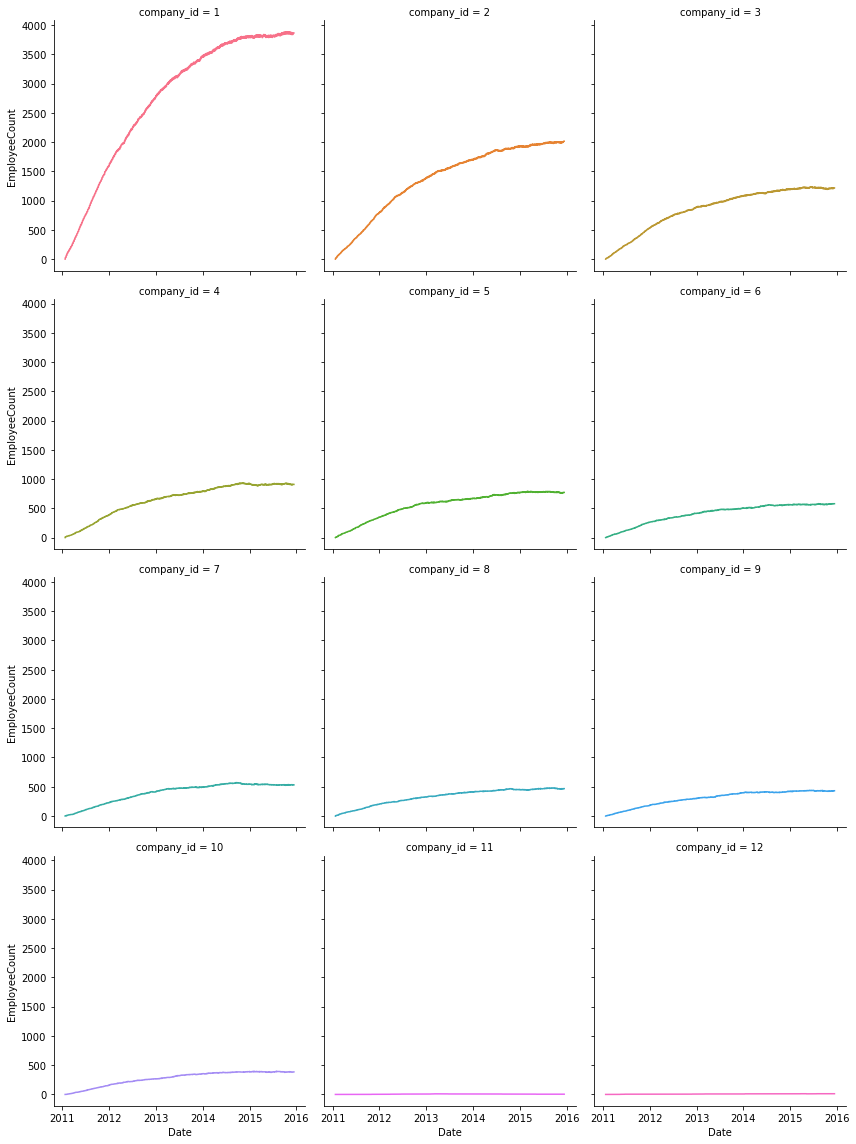

In [1209]:
g = sns.FacetGrid(employeeCount_df, col="company_id",hue="company_id",col_wrap=3,size=4)
g.map(plt.plot,"Date", "EmployeeCount" )

plt.show()

Growth curves obviously vary by company, and intuitively based on company size

We go on and merge the data with the original dataframe, so we know company size each time an employee churned. We also need to add some data where quit-date is NaN (meaning the employee didn't churn over the course of the time period). We use the final employee number for each company in this case.

In [1210]:
employeeCount_df2=employeeCount_df.tail(12)
employeeCount_df2["Date"] = float('nan')*12
employeeCount_df2

/Users/scottmorello/anaconda/envs/my_projects_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Date  company_id  EmployeeCount
21420   NaN           7            532
21421   NaN           4            909
21422   NaN           2           2016
21423   NaN           9            432
21424   NaN           1           3865
21425   NaN           6            579
21426   NaN          10            385
21427   NaN           5            772
21428   NaN           3           1218
21429   NaN           8            468
21430   NaN          11              4
21431   NaN          12             12

In [1212]:
employeeCount_df2=employeeCount_df2.append(employeeCount_df,ignore_index=True)

In [1213]:
employee_retention = pd.merge(employee_retention, employeeCount_df2, left_on = ['company_id','quit_date'], right_on = ['company_id','Date'], how='left')

employee_retention.head(10)

employee_id company_id              dept  seniority    salary  join_date  \
0       13021          7  customer_service         28   89000.0 2014-03-24   
1      825355          7         marketing         20  183000.0 2013-04-29   
2      662910          7  customer_service         20  115000.0 2012-05-14   
3      932790          7         marketing         10   88000.0 2011-11-30   
4       69693          7  customer_service          6   54000.0 2014-03-31   
5      123896          7          engineer         19  231000.0 2015-10-19   
6      922883          7          engineer         16  291000.0 2015-03-31   
7      958767          7  customer_service         19  103000.0 2012-10-08   
8      695896          7             sales          7  100000.0 2012-07-30   
9      707610          7         marketing         27  158000.0 2012-06-25   

   quit_date  churn_time  churn_binary  deptDummy  seniority_group unique_id  \
0 2015-10-30       585.0          True          0                3   7_13021   
1 2014-04-04       340.0          True          4                3  7_825355   
2 2013-06-07       389.0          True          0                3  7_662910   
3 2013-11-22       723.0          True          4                2  7_932790   
4        NaT         NaN         False          0                2   7_69693   
5        NaT         NaN         False          3                3  7_123896   
6        NaT         NaN         False          3                3  7_922883   
7 2013-10-11       368.0          True          0                3  7_958767   
8 2013-07-12       347.0          True          5                2  7_695896   
9 2015-02-20       970.0          True          4                3  7_707610   

   companySize  companySize_cluster       Date  EmployeeCount  
0          532                    0 2015-10-30            532  
1          532                    0 2014-04-04            523  
2          532                    0 2013-06-07            468  
3          532                    0 2013-11-22            485  
4          532                    0        NaT            532  
5          532                    0        NaT            532  
6          532                    0        NaT            532  
7          532                    0 2013-10-11            489  
8          532                    0 2013-07-12            475  
9          532                    0 2015-02-20            543

Now to engineer features for join_date and quit_date month, since it looked as if joins and quits were seasonal

first we look at the joins and quits by month

In [1214]:
employee_retention['join_date_month'] = employee_retention['join_date'].dt.month
employee_retention['quit_date_month'] = employee_retention['quit_date'].dt.month

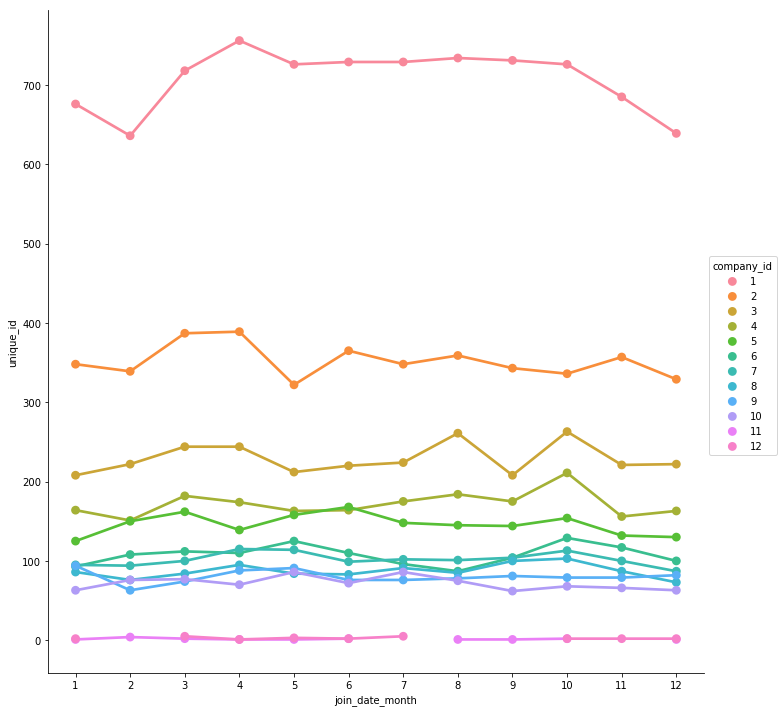

In [1215]:
tmp_dat = employee_retention.groupby(['company_id','join_date_month']).unique_id.count().reset_index()
sns.factorplot(x="join_date_month", y="unique_id", hue="company_id", data=tmp_dat,size=10)
plt.show()


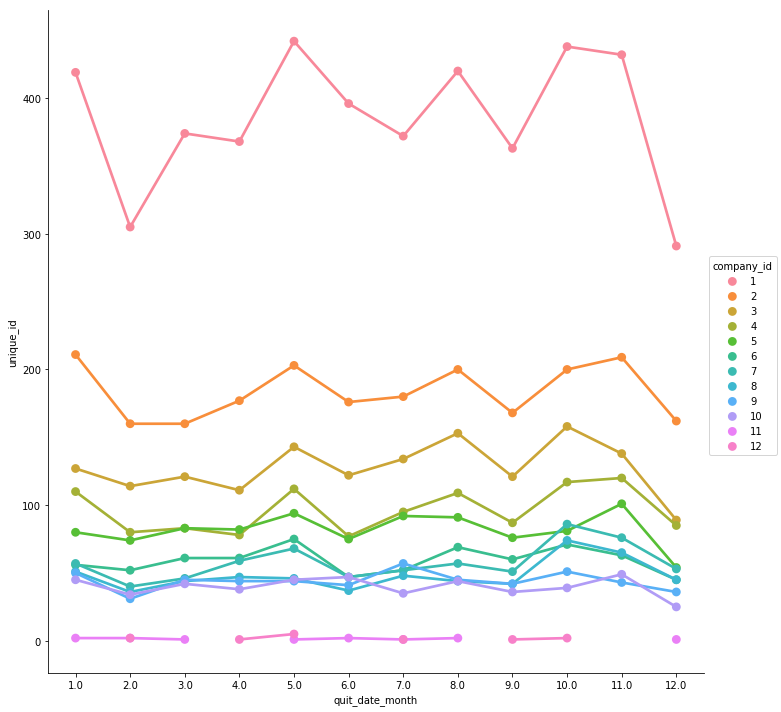

In [1216]:
tmp_dat = employee_retention.groupby(['company_id','quit_date_month']).unique_id.count().reset_index()
sns.factorplot(x="quit_date_month", y="unique_id", hue="company_id", data=tmp_dat,size=10)
plt.show()

There seems to be a bit of variaiton in both join month and quit month, with higher joins and quits in the spring (april) and few in the winter (december). Let's summarize by Qtr to see if that gives us any more resolution.

In [1217]:
def getQtr (x):
    if x in [1,2,3]:
        return 1
    elif x in [4,5,6]:
        return 2
    elif x in [7,8,9]:
        return 3
    elif x in [10,11,12]:
        return 4
    else:
        return float('nan')

employee_retention['quit_date_qtr'] = [getQtr(x) for x in employee_retention["quit_date_month"]]
employee_retention['join_date_qtr'] = [getQtr(x) for x in employee_retention["join_date_month"]]

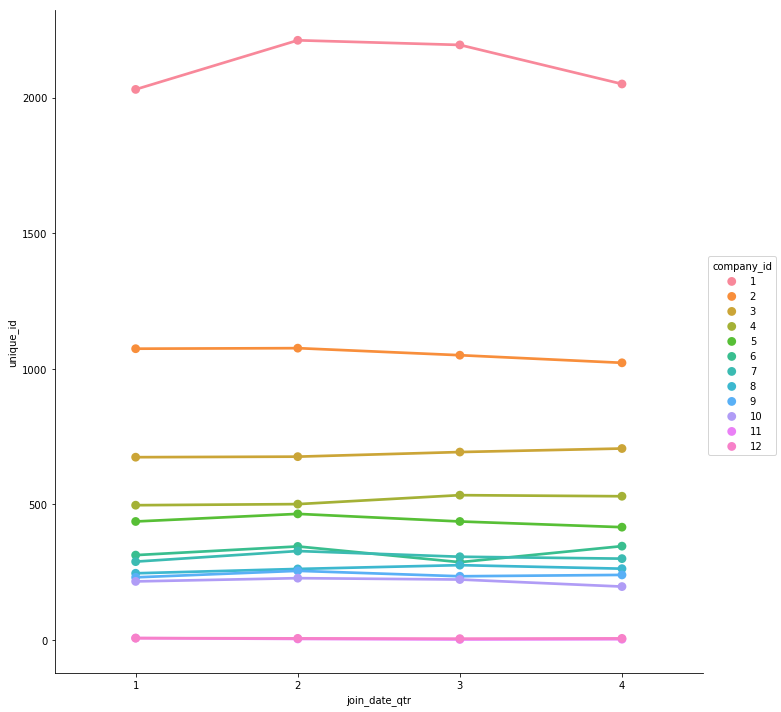

In [1218]:
tmp_dat = employee_retention.groupby(['company_id','join_date_qtr']).unique_id.count().reset_index()
sns.factorplot(x="join_date_qtr", y="unique_id", hue="company_id", data=tmp_dat,size=10)
plt.show()


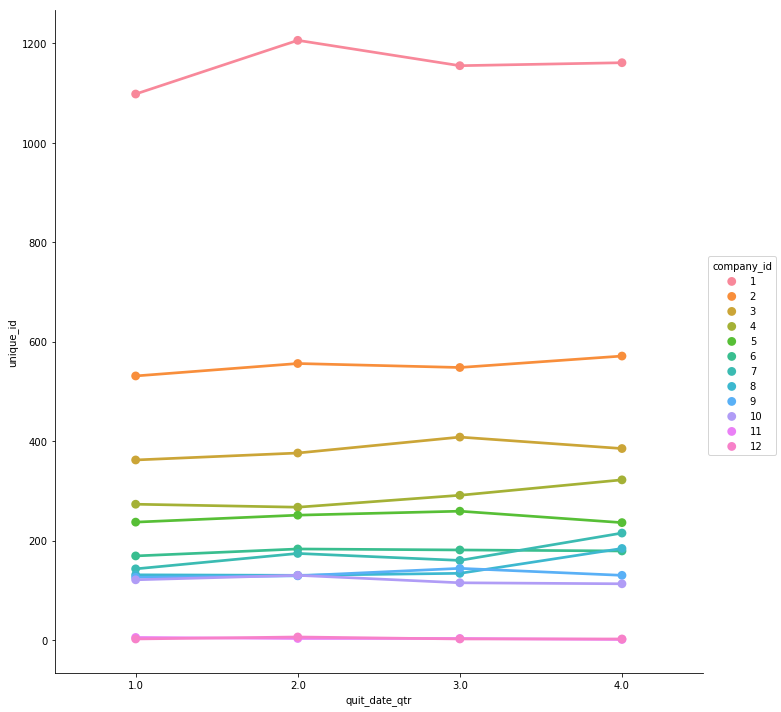

In [1219]:
tmp_dat = employee_retention.groupby(['company_id','quit_date_qtr']).unique_id.count().reset_index()
sns.factorplot(x="quit_date_qtr", y="unique_id", hue="company_id", data=tmp_dat,size=10)
plt.show()

Generally, it looks as if there are slightly more churns in the 4th quarter, and the largest comapny seems to hire in the 2nd quarter, but overall, the greatest variaiton is among companies. This is further evidence that we'll need to deal with companies seaparately in analyses.

Now lets start to understand what's driving churn in the system. Since we have multiple variables which are a mix of categorical and continuous, our observations of each employee span different periods of time, and becuase there are obviously differences among companies, we're going to eventually use a Cox Proportional Hazard model - a type of survival analysis eventually.

First, let's just look at the survivorship curve overall with a Kaplan Meier Fit. We also plot the median from the curve, shoing approximately 50% survivorship.

In [1345]:
employee_retention2=employee_retention

def fillTimeNA(x):
    if pd.isnull(x.quit_date):
        return (datetime(2015,12,13)  - x.join_date).days
    else:
        return (x.quit_date - x.join_date).days

churn_timeAll = employee_retention2.apply(lambda x: fillTimeNA(x), axis = 1)
employee_retention2['churn_timeAll'] = churn_timeAll


E = employee_retention2['churn_binary']
T = employee_retention2['churn_timeAll']


<lifelines.KaplanMeierFitter: fitted with 24700 observations, 11192 censored>

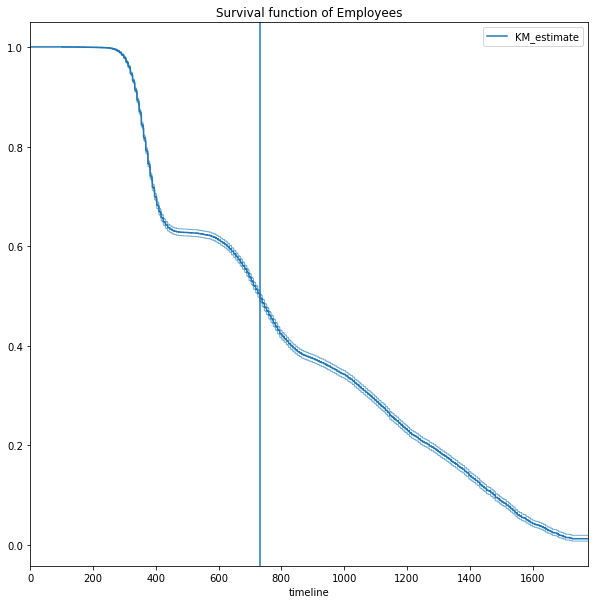

50% survivorship at: 732.0 days


In [1356]:
kmf = ll.KaplanMeierFitter()
kmf.fit(T, event_observed=E) 
kmf.survival_function_
kmf.plot(ci_force_lines=True)
plt.title('Survival function of Employees')
plt.axvline(x=kmf.median_)
plt.show()
print "50% survivorship at: " + str(kmf.median_) +' days'

The biggest drop is at 417 days, which is around 1 year 2 months from join date. We see another dip after that at around the 800 day mark (2x the first drop), suggesting that emplyees generally churn heavily after 1 year at the companies, and then again over the course of the next year. 50% survivorship is at ~2 years (732 days) though.

If this is true, we might see a relatinship between join and quit dates. Those are likely to be noisy though, as we saw before, so let's stick to visualizing things by qtr.

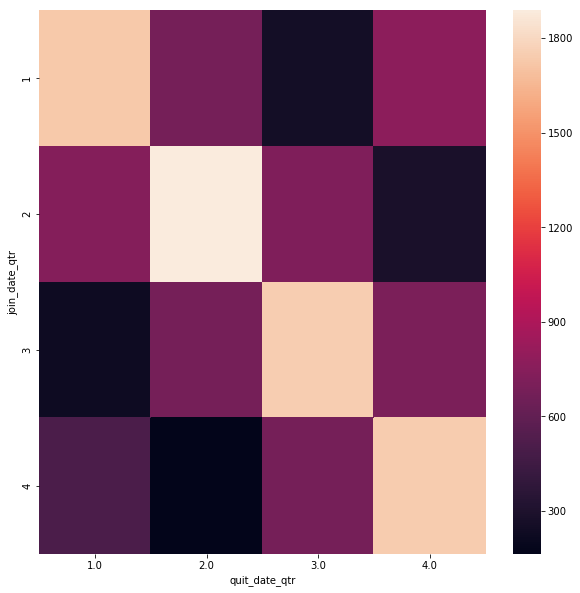

SpearmanrResult(correlation=nan, pvalue=nan)


In [1357]:
qtr_to_plot = employee_retention.groupby(["join_date_qtr", "quit_date_qtr"]).unique_id.count().reset_index().pivot("join_date_qtr", "quit_date_qtr", "unique_id")
sns.heatmap(qtr_to_plot)
plt.show()
print stats.spearmanr(employee_retention['join_date_qtr'], employee_retention['quit_date_qtr'])

There is a pretty strong relationship between join and quit qtr based on the rank correlation, where employees tend to quit in the same quarter they were hired, or adjacent quarters.

Let's dive more deeply into the survivorship curve and look at which factors most explain differences in churn with a Cox Proportional Hazard model as suggested before, as sort of an omnibus test.

Before we user the test, we should probably test the assumtion that the individual survivorship curves don't cross eachother (i.e., only the intercepts vary, but the general shape stays the same). The most likely place for this to be violated is in data shown by company, so let's look at that.

Median survival time of Company 1: 739.0
Median survival time of Company 2: 759.0
Median survival time of Company 3: 711.0
Median survival time of Company 4: 718.0
Median survival time of Company 5: 709.0
Median survival time of Company 6: 724.0
Median survival time of Company 7: 724.0
Median survival time of Company 8: 711.0
Median survival time of Company 9: 732.0
Median survival time of Company 10: 715.0
Median survival time of Company 11: 536.0
Median survival time of Company 12: 662.0


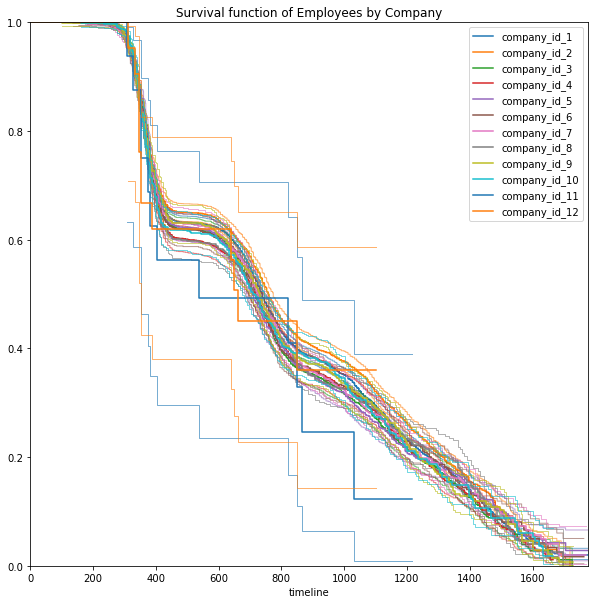

In [1381]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

company_id_1 = (employee_retention["company_id"] == 1)
kmf.fit(T[company_id_1], event_observed=E[company_id_1], label="company_id_1")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of Company 1:", kmf.median_

company_id_2 = (employee_retention["company_id"] == 2)
kmf.fit(T[company_id_2], event_observed=E[company_id_2], label="company_id_2")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of Company 2:", kmf.median_

company_id_3 = (employee_retention["company_id"] == 3)
kmf.fit(T[company_id_3], event_observed=E[company_id_3], label="company_id_3")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of Company 3:", kmf.median_

company_id_4 = (employee_retention["company_id"] == 4)
kmf.fit(T[company_id_4], event_observed=E[company_id_4], label="company_id_4")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of Company 4:", kmf.median_

company_id_5 = (employee_retention["company_id"] == 5)
kmf.fit(T[company_id_5], event_observed=E[company_id_5], label="company_id_5")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of Company 5:", kmf.median_

company_id_6 = (employee_retention["company_id"] == 6)
kmf.fit(T[company_id_6], event_observed=E[company_id_6], label="company_id_6")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of Company 6:", kmf.median_

company_id_7 = (employee_retention["company_id"] == 7)
kmf.fit(T[company_id_7], event_observed=E[company_id_7], label="company_id_7")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of Company 7:", kmf.median_

company_id_8 = (employee_retention["company_id"] == 8)
kmf.fit(T[company_id_8], event_observed=E[company_id_8], label="company_id_8")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of Company 8:", kmf.median_

company_id_9 = (employee_retention["company_id"] == 9)
kmf.fit(T[company_id_9], event_observed=E[company_id_9], label="company_id_9")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of Company 9:", kmf.median_

company_id_10 = (employee_retention["company_id"] == 10)
kmf.fit(T[company_id_10], event_observed=E[company_id_10], label="company_id_10")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of Company 10:", kmf.median_

company_id_11 = (employee_retention["company_id"] == 11)
kmf.fit(T[company_id_11], event_observed=E[company_id_11], label="company_id_11")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of Company 11:", kmf.median_

company_id_12 = (employee_retention["company_id"] == 12)
kmf.fit(T[company_id_12], event_observed=E[company_id_12], label="company_id_12")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of Company 12:", kmf.median_


plt.ylim(0, 1);
plt.title("Survival function of Employees by Company");
plt.show()

We can see thatr companies 11 and 12 are pretty variable - probably becasue of low sample sizes. We might consider removing them from any analysis, or at least running the Cox Proportional Hazard Model stratified by company.

Now let's get the data together and double check the correlations among variables. We'll use an arbitrary cuttoff at 0.40 correlation to evaluate them, and use a spearman rank correlation since most of the data doesn't conform to the assumptions of a pearson correlation.

We'll include the following varables:

* Company ID
* Departments
* Seniority
* Company Size Cluster
* Employee Salary
* Join Date Quarter

We'll need to dummycode the categorical variables, and cener and scale any continuous ones (which should also help with multicolinearity)

In [1434]:
data_x2 = employee_retention2[['company_id','dept','seniority','companySize_cluster','salary','churn_timeAll','churn_binary','join_date_qtr']]
data_x2 = data_x2[data_x2['company_id']!=11]
data_x2 = data_x2[data_x2['company_id']!=12]
data_x2 = pd.get_dummies(data_x2, columns=['dept','company_id','companySize_cluster','join_date_qtr'])
data_x2['salary'] = scale(data_x2['salary'])
data_x2['seniority'] = scale(data_x2['seniority'])



In [1435]:
data_x2.corr(method='spearman')>.4

seniority  salary  churn_timeAll  churn_binary  \
seniority                   True    True          False         False   
salary                      True    True          False         False   
churn_timeAll              False   False           True         False   
churn_binary               False   False          False          True   
dept_customer_service      False   False          False         False   
dept_data_science          False   False          False         False   
dept_design                False   False          False         False   
dept_engineer              False   False          False         False   
dept_marketing             False   False          False         False   
dept_sales                 False   False          False         False   
company_id_1               False   False          False         False   
company_id_2               False   False          False         False   
company_id_3               False   False          False         False   
company_id_4               False   False          False         False   
company_id_5               False   False          False         False   
company_id_6               False   False          False         False   
company_id_7               False   False          False         False   
company_id_8               False   False          False         False   
company_id_9               False   False          False         False   
company_id_10              False   False          False         False   
companySize_cluster_0      False   False          False         False   
companySize_cluster_2      False   False          False         False   
companySize_cluster_3      False   False          False         False   
join_date_qtr_1            False   False          False         False   
join_date_qtr_2            False   False          False         False   
join_date_qtr_3            False   False          False         False   
join_date_qtr_4            False   False          False         False   

                       dept_customer_service  dept_data_science  dept_design  \
seniority                              False              False        False   
salary                                 False              False        False   
churn_timeAll                          False              False        False   
churn_binary                           False              False        False   
dept_customer_service                   True              False        False   
dept_data_science                      False               True        False   
dept_design                            False              False         True   
dept_engineer                          False              False        False   
dept_marketing                         False              False        False   
dept_sales                             False              False        False   
company_id_1                           False              False        False   
company_id_2                           False              False        False   
company_id_3                           False              False        False   
company_id_4                           False              False        False   
company_id_5                           False              False        False   
company_id_6                           False              False        False   
company_id_7                           False              False        False   
company_id_8                           False              False        False   
company_id_9                           False              False        False   
company_id_10                          False              False        False   
companySize_cluster_0                  False              False        False   
companySize_cluster_2                  False              False        False   
companySize_cluster_3                  False              False        False   
join_date_qtr_1                        False              

Salary and Seniority are pretty correlated, as we saw before. Let's see what happens if we keep them in though, and we'll evaluate the impact of their multicolinearity based on their coefficents.

Now let's look at the fit using different penalties to keep the coefficents low, since we have som many varaibles, and because on a quick first pass, the SE on the coefficients was huge, making them difficult to interperet.

In [1436]:
cph10 = ll.CoxPHFitter(penalizer=10.0)
cph100 = ll.CoxPHFitter(penalizer=100.0)
cph1000 = ll.CoxPHFitter(penalizer=1000.0)
cph10000 = ll.CoxPHFitter(penalizer=10000.0)
scores10 = k_fold_cross_validation(cph10, data_x2, duration_col='churn_timeAll', event_col='churn_binary', k=3)
scores100 = k_fold_cross_validation(cph100, data_x2, duration_col='churn_timeAll', event_col='churn_binary', k=3)
scores1000 = k_fold_cross_validation(cph1000, data_x2, duration_col='churn_timeAll', event_col='churn_binary', k=3)
scores10000 = k_fold_cross_validation(cph10000, data_x2, duration_col='churn_timeAll', event_col='churn_binary', k=3)

print 'penalizer=10 mean: ' + str(np.mean(scores10)) +  ' STD: ' + str(np.std(scores10))
print 'penalizer=100 mean: ' + str(np.mean(scores100)) +  ' STD: ' + str(np.std(scores100))
print 'penalizer=1000 mean: ' + str(np.mean(scores1000)) +  ' STD: ' + str(np.std(scores1000))
print 'penalizer=10000 mean: ' + str(np.mean(scores10000)) +  ' STD: ' + str(np.std(scores10000))

penalizer=10 mean: 0.530635346088 STD: 0.00282612732725
penalizer=100 mean: 0.533101400883 STD: 0.00622283260755
penalizer=1000 mean: 0.529426607067 STD: 0.00117803027394
penalizer=10000 mean: 0.52638055013 STD: 0.00410150480379


Based on this, the accuracy of our model is not great, predicting employee churn time with ~53% accuracy based on k-fold (3) cross validation. But, we can get away with a pretty large penalty without sacrificing anyting, so let's use the largest.

We fit the Cox Proportional Hazard Model and look at the coefficents. Anything above 0 contributes to churn, anything below reduces churn.

In [1437]:
#data_x2 = employee_retention[['company_id','dept','salary','seniority_group','EmployeeCount','companySize_cluster','churn_time','churn_binary']]
data_x = employee_retention2[['company_id','dept','seniority','salary','companySize_cluster','churn_timeAll','churn_binary','join_date_qtr']]
data_x = data_x[data_x['company_id']!=11]
data_x = data_x[data_x['company_id']!=12]
data_x = pd.get_dummies(data_x, columns=['dept','join_date_qtr','companySize_cluster'])
data_x['salary'] = scale(data_x['salary'])
data_x['seniority'] = scale(data_x['seniority'])
#data_x['EmployeeCount'] = scale(data_x['EmployeeCount'])




In [1438]:
cph = ll.CoxPHFitter(penalizer=10000.0)
cph.fit(data_x, duration_col='churn_timeAll', event_col='churn_binary',strata = 'company_id',show_progress=True)
cph.print_summary()

Convergence completed after 4 iterations.
n=24660, number of events=13484

                         coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
seniority              0.0147     1.0148    0.0070  2.0949 0.0362      0.0009      0.0284    *
salary                -0.0366     0.9640    0.0077 -4.7502 0.0000     -0.0518     -0.0215  ***
dept_customer_service  0.0145     1.0146    0.0158  0.9211 0.3570     -0.0164      0.0455     
dept_data_science     -0.0533     0.9481    0.0210 -2.5323 0.0113     -0.0945     -0.0120    *
dept_design            0.0262     1.0266    0.0291  0.9018 0.3672     -0.0308      0.0833     
dept_engineer         -0.0705     0.9319    0.0187 -3.7813 0.0002     -0.1071     -0.0340  ***
dept_marketing         0.0389     1.0397    0.0207  1.8858 0.0593     -0.0015      0.0794    .
dept_sales             0.0675     1.0698    0.0207  3.2678 0.0011      0.0270      0.1080   **
join_date_qtr_1        0.0025     1.0025    0.0167  0.1485 0.8819     

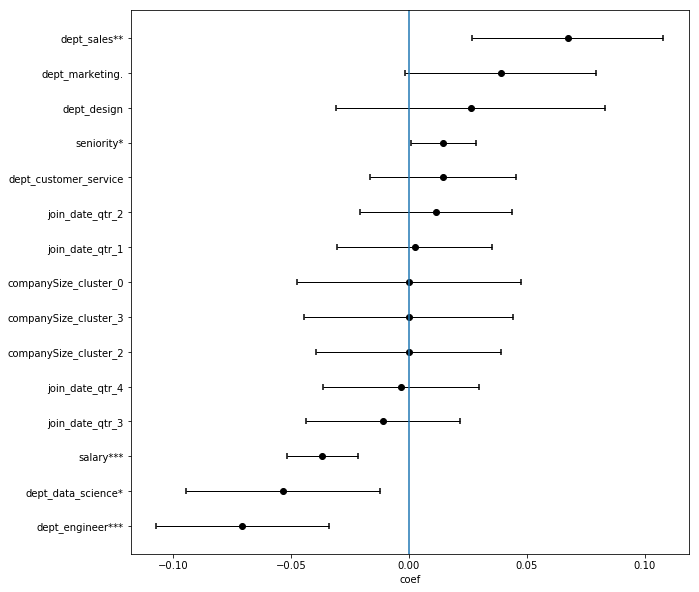

seniority    salary  dept_customer_service  dept_data_science  \
coef   0.014669 -0.036636               0.014533          -0.053255   

      dept_design  dept_engineer  dept_marketing  dept_sales  join_date_qtr_1  \
coef     0.026242      -0.070542        0.038948    0.067505         0.002478   

      join_date_qtr_2  join_date_qtr_3  join_date_qtr_4  \
coef         0.011671        -0.010865        -0.003421   

      companySize_cluster_0  companySize_cluster_2  companySize_cluster_3  
coef           1.768604e-15          -1.519532e-15           5.154128e-17

In [1439]:
plt.rcParams["figure.figsize"]=[10,10]
cph.plot()
plt.axvline(x=0)
plt.show()
cph.hazards_

Based on this it seems like the Sales and Marketing departments have more churn than the other departments, and that Engineers and Data Scientists have the lowest churn. This could be an inherent property of the job, or be due to salary since Salary also reduces churn.

Seniority also seems to lead to more churn, possibly becuase people are already older and close to retirement once they get to a company.

Let's dig into these insights just a bit more with some plots and other survivorship curves.

First, lets look into how salary and seniority might be influecing churn.

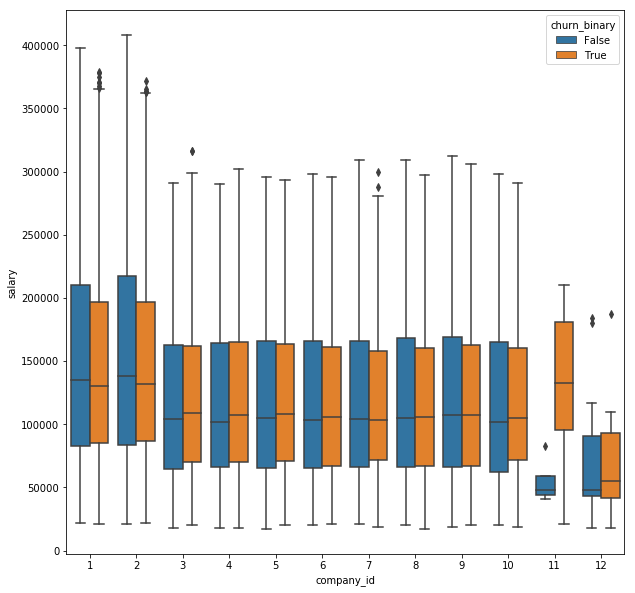

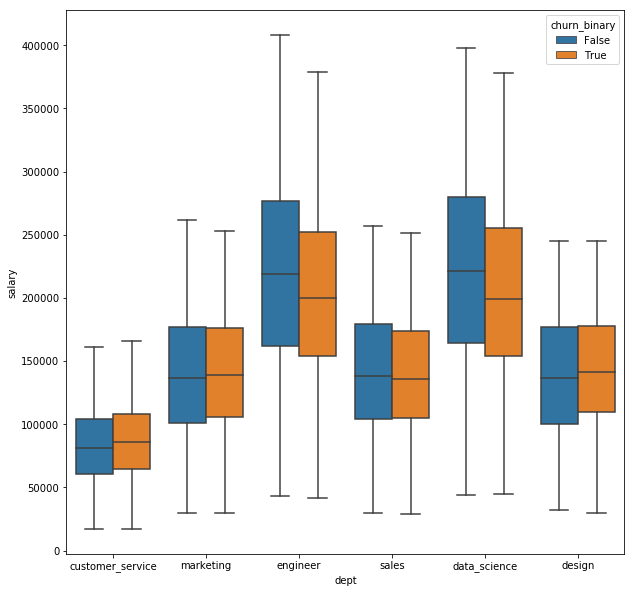

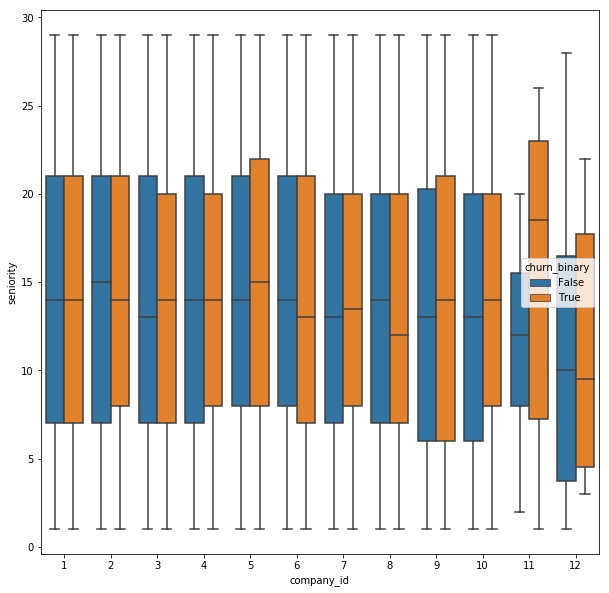

In [1441]:
sns.boxplot(x="company_id", y="salary", hue = 'churn_binary',data=employee_retention, dodge=True)
plt.show()

sns.boxplot(x="dept", y="salary", hue = 'churn_binary',data=employee_retention, dodge=True)
plt.show()


sns.boxplot(x="company_id", y="seniority", hue = 'churn_binary',data=employee_retention, dodge=True)
plt.show()

Looks like employees who churned had slightly lower salaries overall than those who did not. We also find that, as suspected, the salaries of Data Scientists and Engineers is mugh higher than others, and that the difference among departments is larger than the difference between churn and not-churn generally at a company.

The effect of senority is less clear. We should also keep in mind that the analysis did not include companies 11 and 12 because they were small and variable, and seem to be findamentally differnt than the other, larger, companies.

Let's go on to look at survivorship curves for each department, and do pairwise tests of differences in the curves.

Median survival time of customer_service: 717.0
Median survival time of data_science: 788.0
Median survival time of design: 711.0
Median survival time of engineer: 784.0
Median survival time of marketing: 711.0
Median survival time of sales: 697.0

customer_service vs data_science True
customer_service vs design False
customer_service vs engineer True
customer_service vs marketing False
customer_service vs sales False
data_science vs design True
data_science vs engineer False
data_science vs marketing True
data_science vs sales True
design vs engineer True
design vs marketing False
design vs sales False
engineer vs marketing True
engineer vs sales True
marketing vs sales False


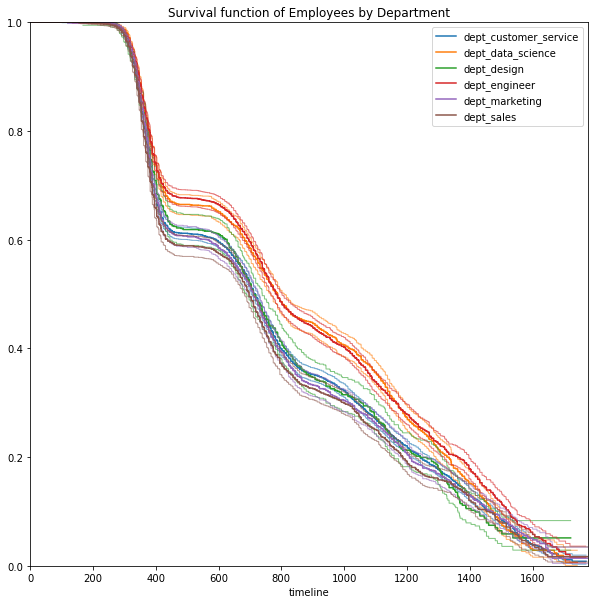

In [1404]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

dept_customer_service = (employee_retention["dept"] == "customer_service")
kmf.fit(T[dept_customer_service], event_observed=E[dept_customer_service], label="dept_customer_service")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of customer_service:", kmf.median_

dept_data_science = (employee_retention["dept"] == "data_science")
kmf.fit(T[dept_data_science], event_observed=E[dept_data_science], label="dept_data_science")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of data_science:", kmf.median_

dept_design = (employee_retention["dept"] == "design")
kmf.fit(T[dept_design], event_observed=E[dept_design], label="dept_design")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of design:", kmf.median_

dept_engineer = (employee_retention["dept"] == "engineer")
kmf.fit(T[dept_engineer], event_observed=E[dept_engineer], label="dept_engineer")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of engineer:", kmf.median_

dept_marketing = (employee_retention["dept"] == "marketing")
kmf.fit(T[dept_marketing], event_observed=E[dept_marketing], label="dept_marketing")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of marketing:", kmf.median_

dept_sales = (employee_retention["dept"] == "sales")
kmf.fit(T[dept_sales], event_observed=E[dept_sales], label="dept_sales")
kmf.plot(ax=ax, ci_force_lines=True)
print "Median survival time of sales:", kmf.median_
print""
results = logrank_test( T[dept_customer_service],T[dept_data_science], E[dept_customer_service], E[dept_data_science])
print "customer_service vs data_science " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_customer_service],T[dept_design], E[dept_customer_service], E[dept_design])
print "customer_service vs design " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_customer_service],T[dept_engineer], E[dept_customer_service], E[dept_engineer])
print "customer_service vs engineer " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_customer_service],T[dept_marketing], E[dept_customer_service], E[dept_marketing])
print "customer_service vs marketing " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_customer_service],T[dept_sales], E[dept_customer_service], E[dept_sales])
print "customer_service vs sales " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_data_science],T[dept_design], E[dept_data_science], E[dept_design])
print "data_science vs design " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_data_science],T[dept_engineer], E[dept_data_science], E[dept_engineer])
print "data_science vs engineer " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_data_science],T[dept_marketing], E[dept_data_science], E[dept_marketing])
print "data_science vs marketing " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_data_science],T[dept_sales], E[dept_data_science], E[dept_sales])
print "data_science vs sales " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_design],T[dept_engineer], E[dept_design], E[dept_engineer])
print "design vs engineer " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_design],T[dept_marketing], E[dept_design], E[dept_marketing])
print "design vs marketing " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_design],T[dept_sales], E[dept_design], E[dept_sales])
print "design vs sales " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_engineer],T[dept_marketing], E[dept_engineer], E[dept_marketing])
print "engineer vs marketing " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_engineer],T[dept_sales], E[dept_engineer], E[dept_sales])
print "engineer vs sales " + str(results.p_value*15<0.05)

results = logrank_test( T[dept_marketing],T[dept_sales], E[dept_marketing], E[dept_sales])
print "marketing vs sales " + str(results.p_value*15<0.05)

plt.ylim(0, 1);
plt.title("Survival function of Employees by Department");
plt.show()

We can see that Data Scientists and Engineers survivorship is alomost 100 days longer than somne other departments (e.g., sales).  This is, more than likely, driven by salary as seen before.

Overall, it we find the following information about churn in these companies:

* After one year of employment, there is a high risk of churn rate in companies. There is another slight risk after two years, and genereally, employees have a >50% risk of churning past 2 years.

* Employees tend to churn in the same quarter they were hired, so focus on retention efforts for each employee based on their hire date.

* Of all the departments, employees in Sales have the greatst risk of churn. This is despite the fact that their salaries are on par with marketing and design, and higher than customer service!

* Data Scientists and Engineers are least at risk of churn, and this is - more than likely - due to their higher salaries.

More information, and aditional analysis, is obviously needed. Useful new information to gather would be:

* Annual Salary, or start and end salary of an individual. Considering the imnportance of salary, it would be useful to know if emoployees had incentives not to churn (inceases in salaray)

* Whether employees were Temps or not. It could be that the high churn after 1 year is intentional

* Employee age: Perhaps the churn after 1 year is from young employees exploring different fields.